In [2]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

env: KERAS_BACKEND=tensorflow


In [3]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


In [4]:
#調整資料大小以及正規化
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [6]:
#VAE structure
enc_1 = Dense(300, activation='relu')
enc_2 = Dense(50, activation='relu')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(50, activation='relu')
dec_2 = Dense(300, activation='relu')
dec_1 = Dense(784, activation='relu')

#
x = Input(shape=(784,))
enc_x = enc_1(x)
enc_x = enc_2(enc_x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

dec_x = dec_3(z)
dec_x = dec_2(dec_x)
x_hat = dec_1(dec_x)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          235500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           15050       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            102         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [8]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [9]:
VAE.compile(loss=vae_loss, optimizer=Adam())
VAE.fit(x_train, x_train, batch_size=32, epochs=30)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
60000/60000 [==============================] - 18s 306us/step - loss: 459.3917
Epoch 2/30
60000/60000 [==============================] - 16s 274us/step - loss: 407.4909
Epoch 3/30
60000/60000 [==============================] - 19s 309us/step - loss: 394.7175
Epoch 4/30
60000/60000 [==============================] - 21s 344us/step - loss: 390.0731
Epoch 5/30
60000/60000 [==============================] - 19s 318us/step - loss: 388.3195
Epoch 6/30
60000/60000 [==============================] - 20s 333us/step - loss: 385.0491
Epoch 7/30
60000/60000 [==============================] - 18s 301us/step - loss: 377.3743
Epoch 8/30
60000/60000 [==============================] - 18s 295us/step - loss: 370.8347
Epoch 9/30
60000/60000 [==============================] - 17s 285us/step - loss: 370.3386
Epoch 10/30
60000/60000 [==============================] - 18s 308us/step - loss: 367.3076
Epoch 11/30
60000/60000 [==========================

In [10]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 250,652
Trainable params: 250,652
Non-trainable params: 0
_________________________________________________________________


In [12]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(dec_3(h_input))))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_6 (Dense)              (None, 300)               15300     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               235984    
Total params: 251,434
Trainable params: 251,434
Non-trainable params: 0
_________________________________________________________________


In [13]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 20242 圖的 latent 表示為 [[-0.839362   -0.43896097]]


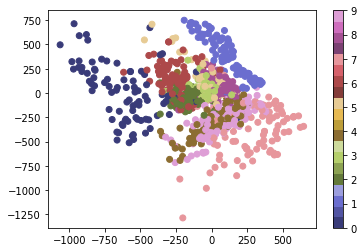

In [14]:
indices = np.random.randint(x_test.shape[0], size=1000)
latents = VAE_Encoder.predict(x_test[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap='tab20b')
plt.colorbar()

In [15]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [16]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

(-0.5, 419.5, 419.5, -0.5)

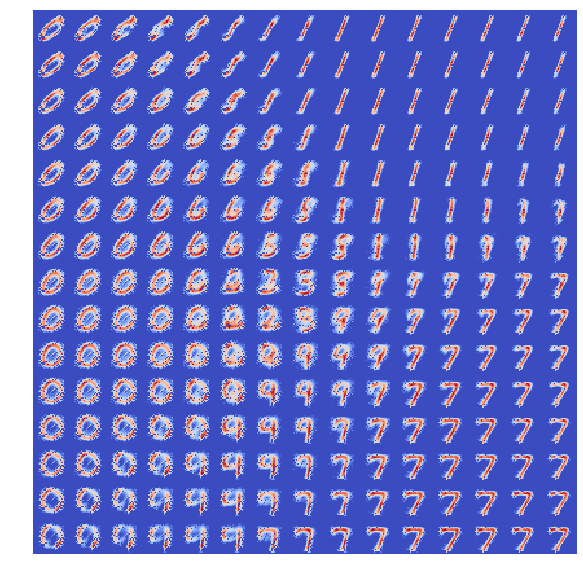

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='coolwarm')
plt.axis('off')

In [18]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [19]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

interact(inBetween, t=FloatSlider(value=0.5, min=0, max=1.0,step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>